In [2]:
import warnings
from datetime import datetime
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
from scipy import stats
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv('dataset.csv', parse_dates=['Date'], index_col='Date')

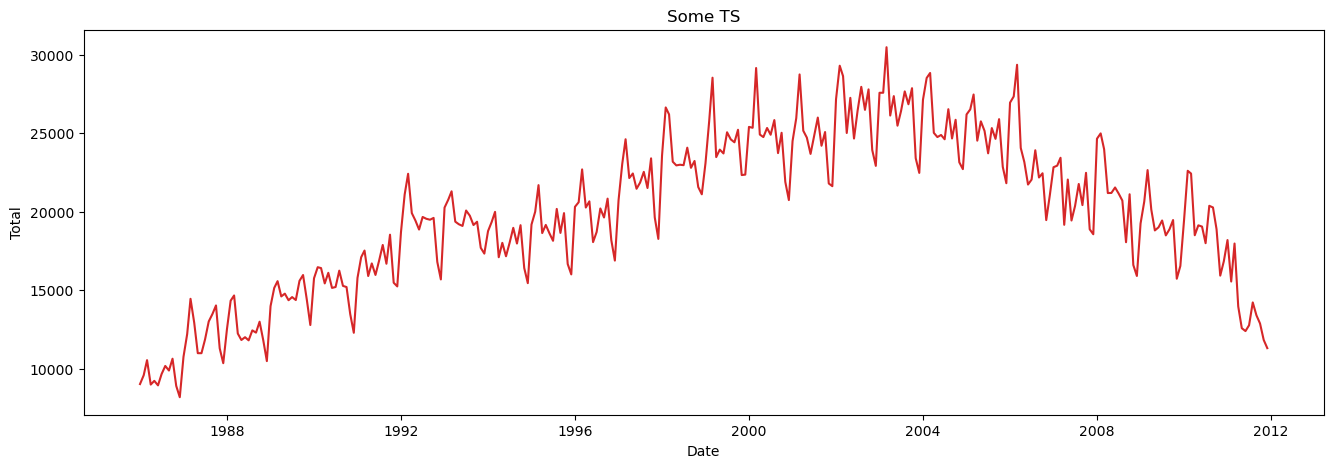

In [4]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Total', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.Total, title='Some TS') 

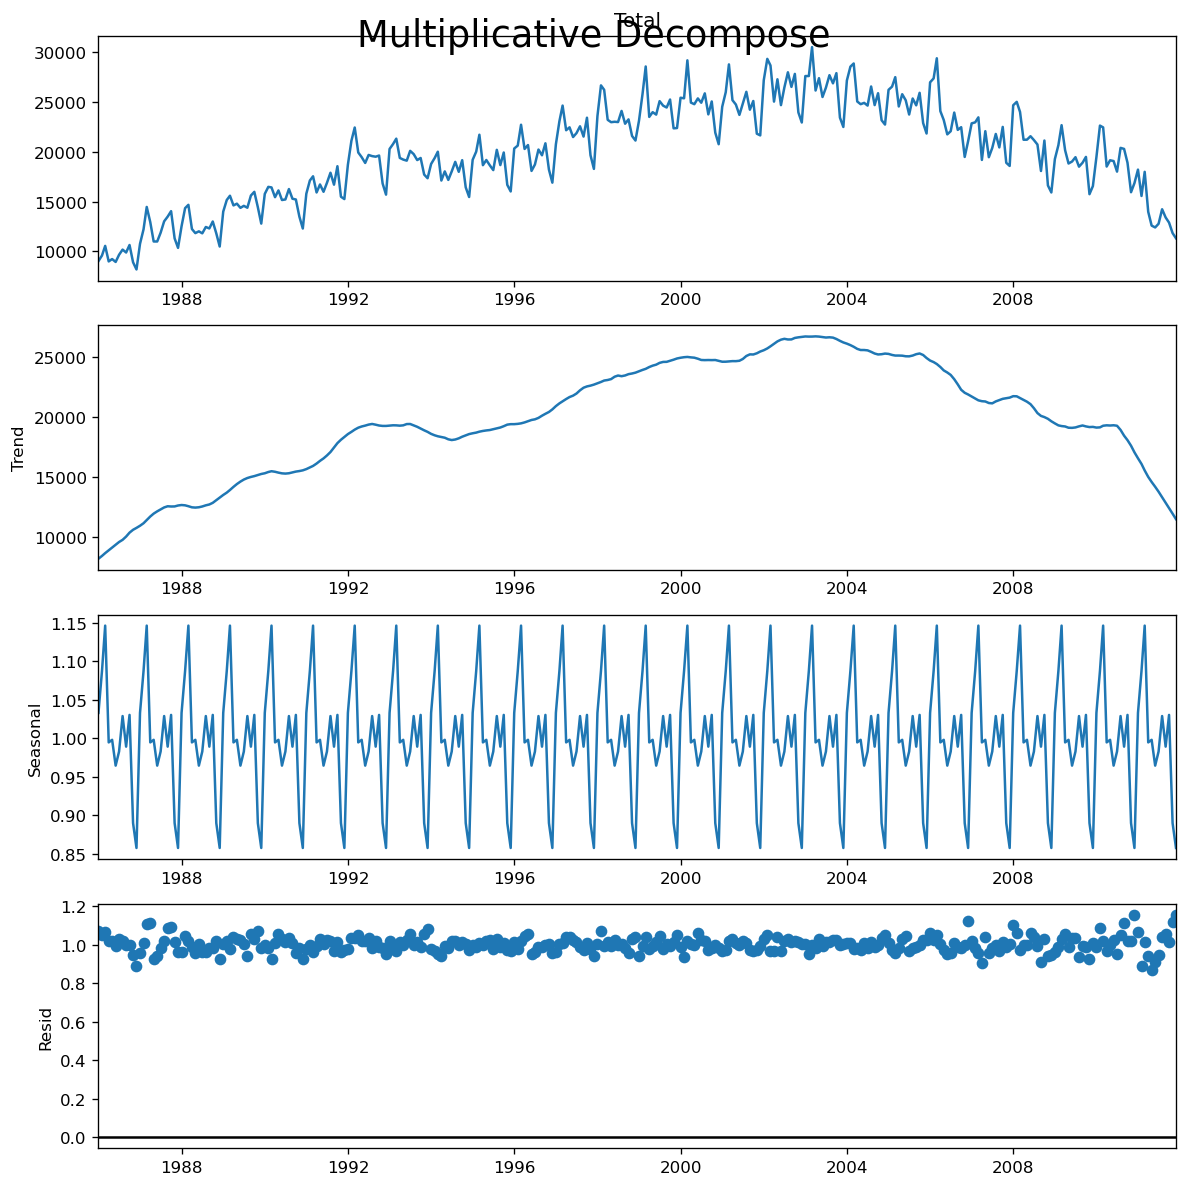

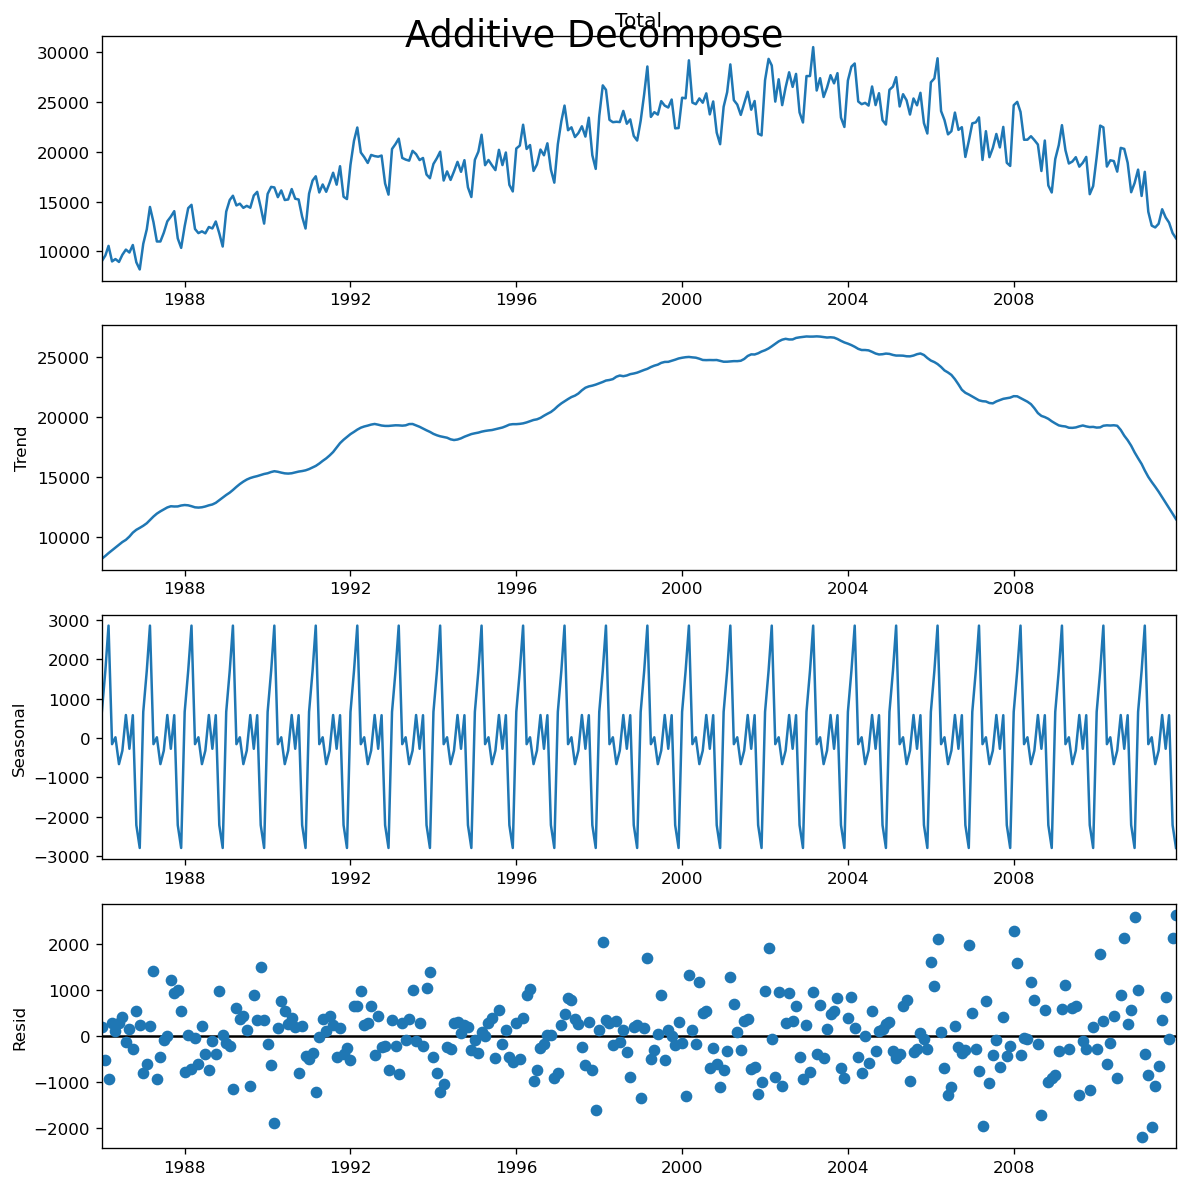

In [5]:
result_mul = seasonal_decompose(df['Total'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['Total'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

* Посмотрев на декомпозиции, можно сделать вывод о том, что на данном ряду есть сезонность, два тренда: восходящий и нисходящий. Так как ряд сезонный, также можно сделать вывод о том, что предоставленный ряд не стационарен, но это мы проверим далее. Поскольку сезонные колебания относительно постоянны по времени, мы используем аддитивную модель для анализа. Соответственно, посмотрев на график остатков (Resid), можно сделать вывод, что со временем разброс ошибок увеличивается.

* Для проверки на стационарность, проведем тест Дики Фуллера (ADF Test).

Критерий Дики-Фуллера: p=0.755496


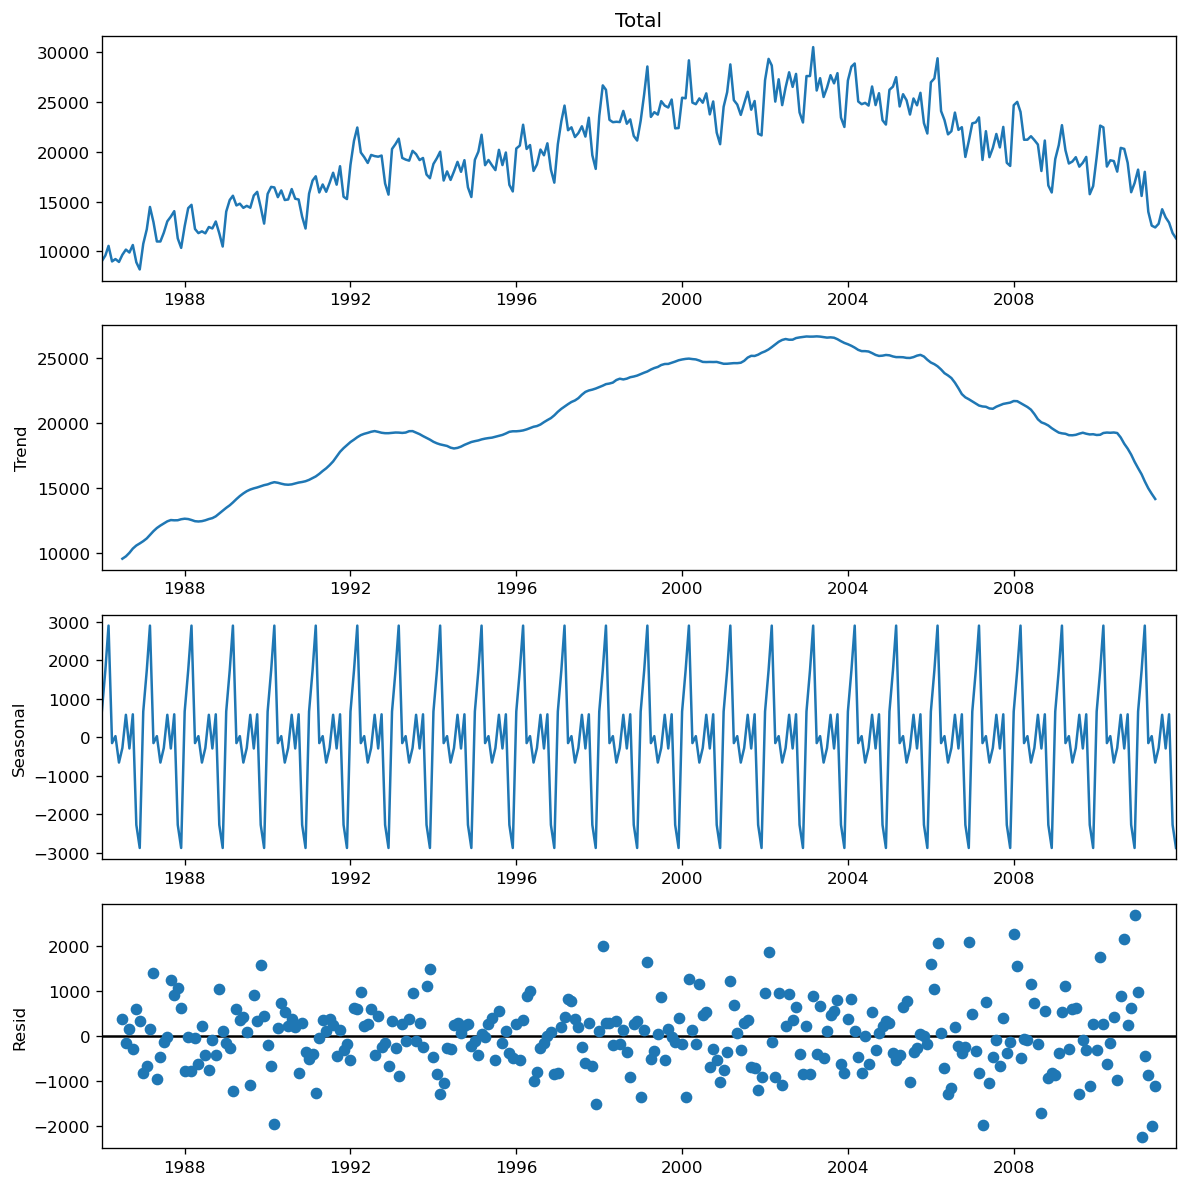

In [6]:
sm.tsa.seasonal_decompose(df.Total).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Total)[1])

* Поскольку p-value > 0.05, то мы не можем отвергнуть гипотезу H<sub>0</sub> о том, что ряд не стационарен. Попробуем привести ряд к стационарности с помощью следующих возможных методов:
    - Взять разность
    - Взять логарифм
    - Взять n-ый корень
    - Комбинация указанного выше

Критерий Дики-Фуллера: p=0.501138


<Figure size 1800x1200 with 0 Axes>

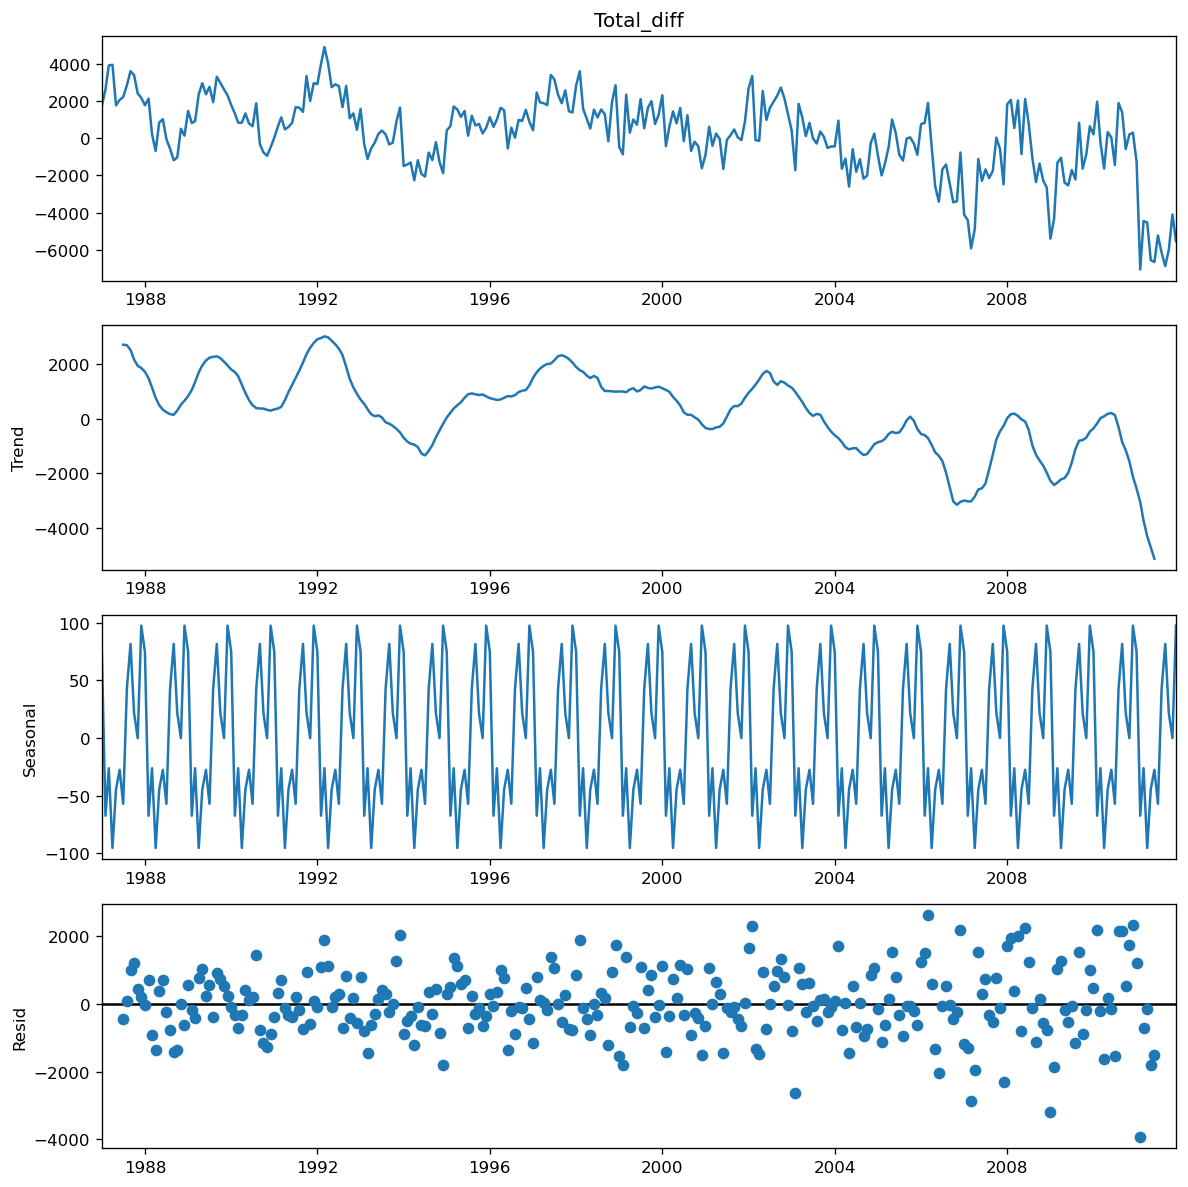

In [7]:
df['Total_diff'] = df.Total - df.Total.shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df.Total_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Total_diff[12:])[1])

* Поскольку нам не удалось привести ряд к стационарности, попробуем добавить обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1800x1200 with 0 Axes>

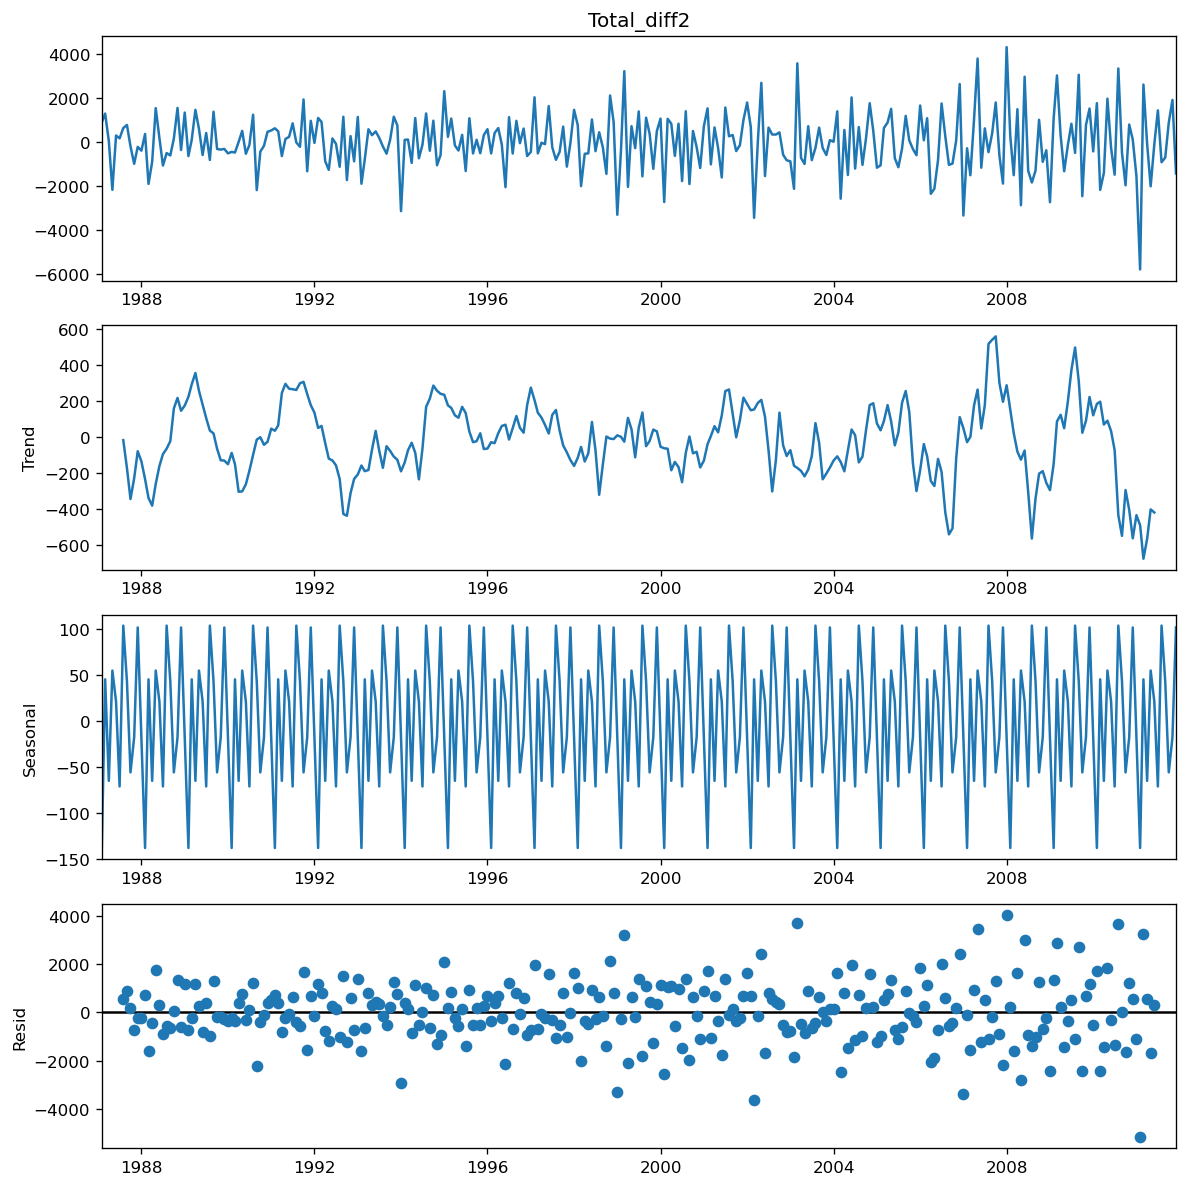

In [8]:
df['Total_diff2'] = df.Total_diff - df.Total_diff.shift(1)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df.Total_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Total_diff2[13:])[1])

Критерий Дики-Фуллера: p=0.000000


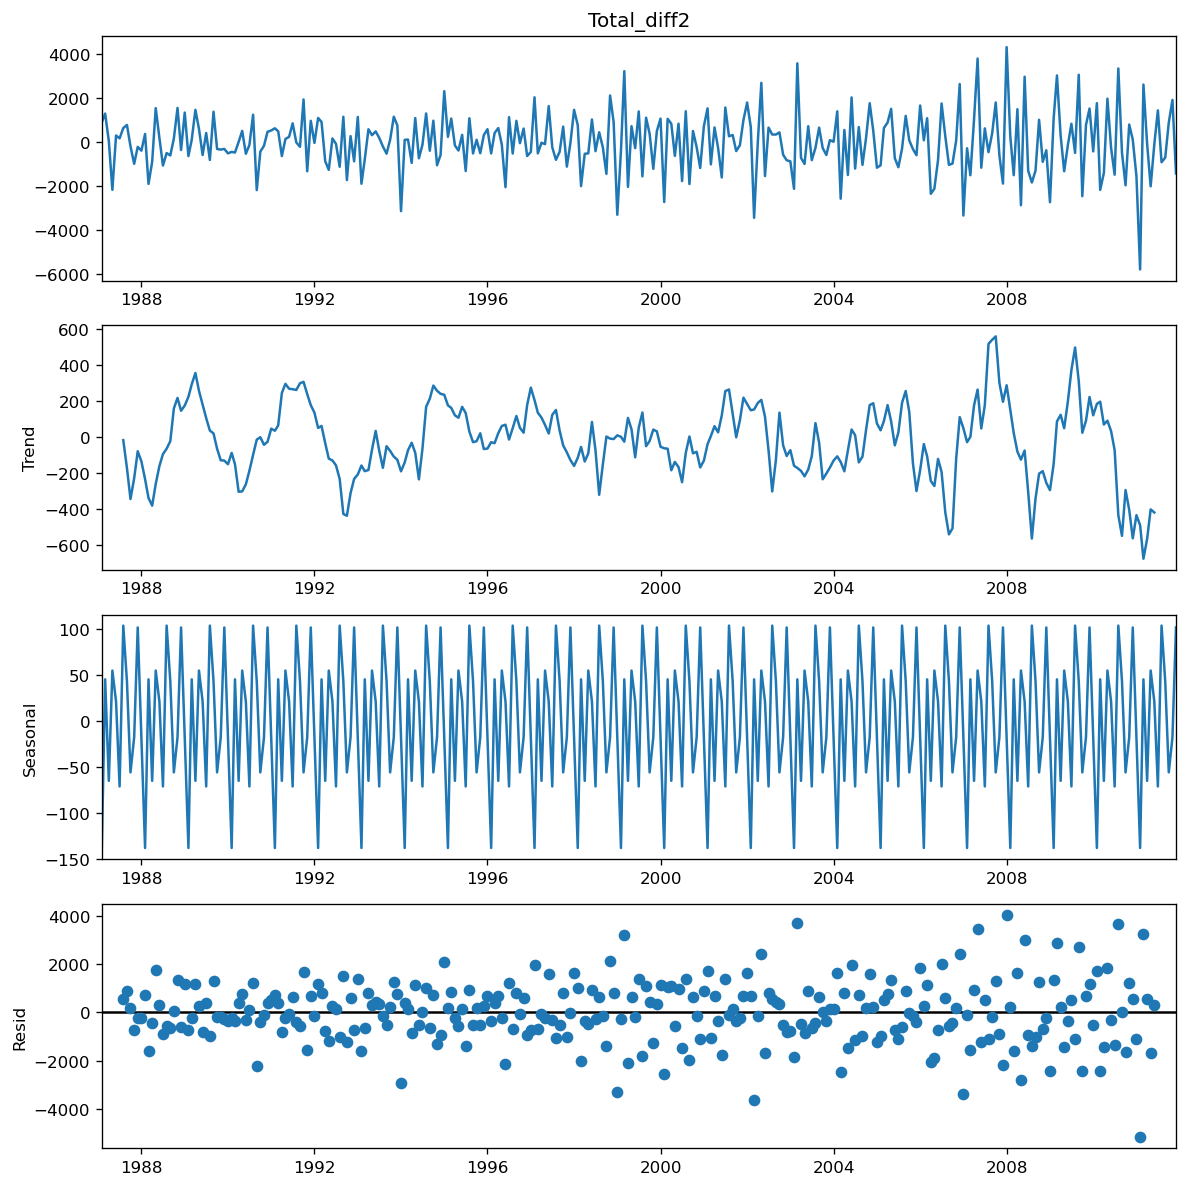

In [11]:
df['Total_diff2'] = df.Total_diff - df.Total_diff.shift(1)
#plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df.Total_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Total_diff2[13:])[1])

* По графикам видно, что удалось получить стационарность ряда, теперь нужно учесть сезонность.

In [13]:
trend_ts = df.Total_diff2
trend_ts.dropna(inplace=True)

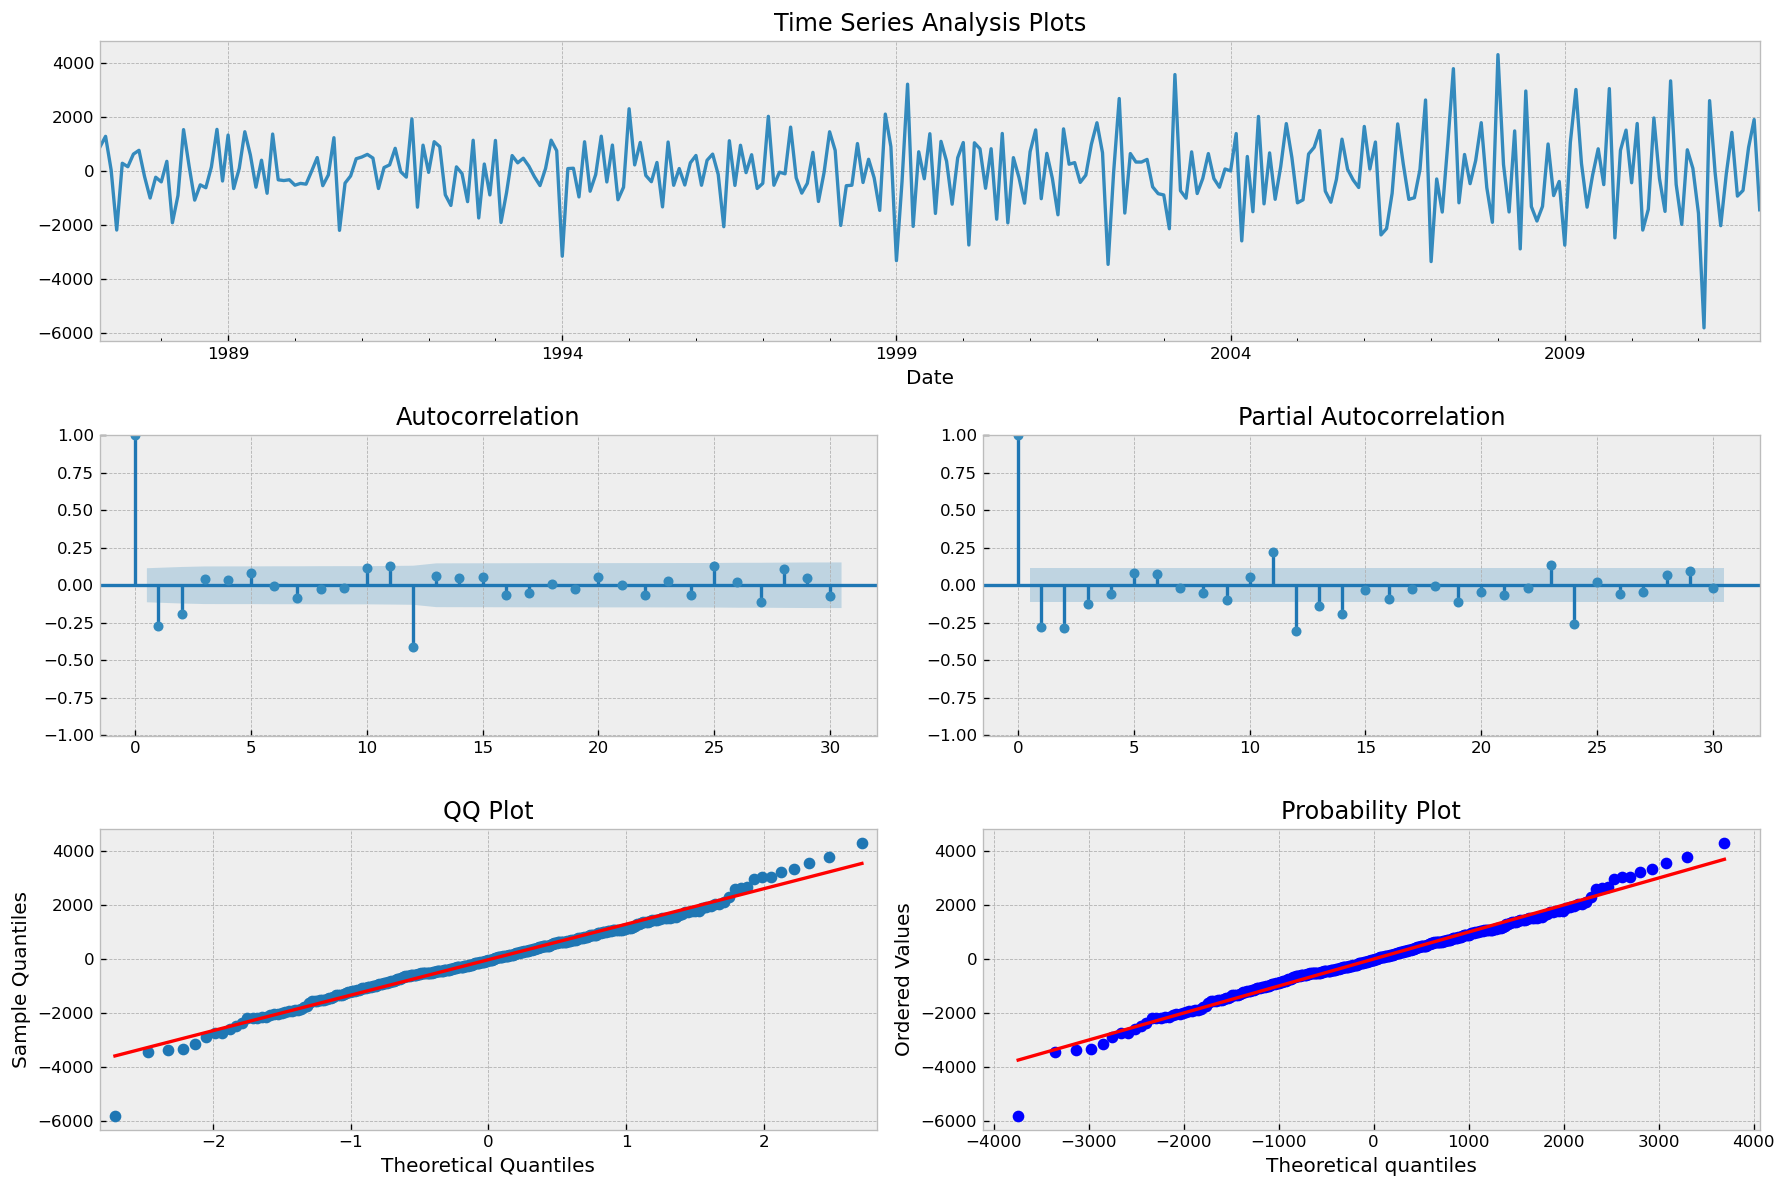

In [14]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        _ = plt.figure(figsize=figsize)
        
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

np.random.seed(1)

# plot of discrete white noise
tsplot(trend_ts, lags=30)

По ACF графику видно, что параметр q = 12, а по графику PACF p = 24 (брали самый правый лаг). Обучив SARIMAX на параметрах ps = range(20, 25) и qs = range(10, 15) по AIC было видно, что чем меньше параметры p и q, тем лучше модель. Соответственно мы решили проверить, возможно с параметрами ps и qs моделька обучится еще лучше.

In [15]:
df['ts_box'], lmbda = stats.boxcox(df.Total)

In [16]:
ps = list(range(0, 5)) + list(range(20, 25))
d=1
qs = list(range(0, 5)) + list(range(10, 15))
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [17]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

500

In [18]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    try:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(df.ts_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        
        results.append([param, model.aic])
    except Exception as e:
        print(e)
        pass

warnings.filterwarnings('default')

 50%|████████████████████▌                    | 251/500 [16:43<41:32, 10.01s/it]

wrong parameters: (20, 0, 1, 0)
wrong parameters: (20, 0, 2, 0)
wrong parameters: (20, 0, 3, 0)
wrong parameters: (20, 0, 4, 0)


 51%|████████████████████▉                    | 256/500 [16:50<16:34,  4.08s/it]

wrong parameters: (20, 1, 1, 0)
wrong parameters: (20, 1, 2, 0)
wrong parameters: (20, 1, 3, 0)
wrong parameters: (20, 1, 4, 0)


 52%|█████████████████████▍                   | 261/500 [16:56<10:50,  2.72s/it]

wrong parameters: (20, 2, 1, 0)
wrong parameters: (20, 2, 2, 0)
wrong parameters: (20, 2, 3, 0)
wrong parameters: (20, 2, 4, 0)


 53%|█████████████████████▊                   | 266/500 [17:03<08:27,  2.17s/it]

wrong parameters: (20, 3, 1, 0)
wrong parameters: (20, 3, 2, 0)
wrong parameters: (20, 3, 3, 0)
wrong parameters: (20, 3, 4, 0)


 54%|██████████████████████▏                  | 271/500 [17:10<07:12,  1.89s/it]

wrong parameters: (20, 4, 1, 0)
wrong parameters: (20, 4, 2, 0)
wrong parameters: (20, 4, 3, 0)
wrong parameters: (20, 4, 4, 0)


 55%|██████████████████████▋                  | 276/500 [17:18<06:39,  1.78s/it]

wrong parameters: (20, 10, 1, 0)
wrong parameters: (20, 10, 2, 0)
wrong parameters: (20, 10, 3, 0)
wrong parameters: (20, 10, 4, 0)


 56%|███████████████████████                  | 281/500 [17:27<06:22,  1.75s/it]

wrong parameters: (20, 11, 1, 0)
wrong parameters: (20, 11, 2, 0)
wrong parameters: (20, 11, 3, 0)
wrong parameters: (20, 11, 4, 0)


 57%|███████████████████████▍                 | 286/500 [17:36<06:17,  1.76s/it]

wrong parameters: (20, 12, 1, 0)
wrong parameters: (20, 12, 2, 0)
wrong parameters: (20, 12, 3, 0)
wrong parameters: (20, 12, 4, 0)


 58%|███████████████████████▊                 | 291/500 [17:45<06:14,  1.79s/it]

wrong parameters: (20, 13, 1, 0)
wrong parameters: (20, 13, 2, 0)
wrong parameters: (20, 13, 3, 0)
wrong parameters: (20, 13, 4, 0)


 59%|████████████████████████▎                | 296/500 [17:54<06:13,  1.83s/it]

wrong parameters: (20, 14, 1, 0)
wrong parameters: (20, 14, 2, 0)
wrong parameters: (20, 14, 3, 0)
wrong parameters: (20, 14, 4, 0)


 60%|████████████████████████▋                | 301/500 [17:57<04:40,  1.41s/it]

wrong parameters: (21, 0, 1, 0)
wrong parameters: (21, 0, 2, 0)
wrong parameters: (21, 0, 3, 0)
wrong parameters: (21, 0, 4, 0)


 61%|█████████████████████████                | 306/500 [18:03<04:27,  1.38s/it]

wrong parameters: (21, 1, 1, 0)
wrong parameters: (21, 1, 2, 0)
wrong parameters: (21, 1, 3, 0)
wrong parameters: (21, 1, 4, 0)


 62%|█████████████████████████▌               | 311/500 [18:10<04:23,  1.39s/it]

wrong parameters: (21, 2, 1, 0)
wrong parameters: (21, 2, 2, 0)
wrong parameters: (21, 2, 3, 0)
wrong parameters: (21, 2, 4, 0)


 63%|█████████████████████████▉               | 316/500 [18:18<04:22,  1.43s/it]

wrong parameters: (21, 3, 1, 0)
wrong parameters: (21, 3, 2, 0)
wrong parameters: (21, 3, 3, 0)
wrong parameters: (21, 3, 4, 0)


 64%|██████████████████████████▎              | 321/500 [18:25<04:17,  1.44s/it]

wrong parameters: (21, 4, 1, 0)
wrong parameters: (21, 4, 2, 0)
wrong parameters: (21, 4, 3, 0)
wrong parameters: (21, 4, 4, 0)


 65%|██████████████████████████▋              | 326/500 [18:34<04:26,  1.53s/it]

wrong parameters: (21, 10, 1, 0)
wrong parameters: (21, 10, 2, 0)
wrong parameters: (21, 10, 3, 0)
wrong parameters: (21, 10, 4, 0)


 66%|███████████████████████████▏             | 331/500 [18:43<04:37,  1.64s/it]

wrong parameters: (21, 11, 1, 0)
wrong parameters: (21, 11, 2, 0)
wrong parameters: (21, 11, 3, 0)
wrong parameters: (21, 11, 4, 0)


 67%|███████████████████████████▌             | 336/500 [18:53<04:41,  1.72s/it]

wrong parameters: (21, 12, 1, 0)
wrong parameters: (21, 12, 2, 0)
wrong parameters: (21, 12, 3, 0)
wrong parameters: (21, 12, 4, 0)


 68%|███████████████████████████▉             | 341/500 [19:02<04:41,  1.77s/it]

wrong parameters: (21, 13, 1, 0)
wrong parameters: (21, 13, 2, 0)
wrong parameters: (21, 13, 3, 0)
wrong parameters: (21, 13, 4, 0)


 69%|████████████████████████████▎            | 346/500 [19:12<04:42,  1.83s/it]

wrong parameters: (21, 14, 1, 0)
wrong parameters: (21, 14, 2, 0)
wrong parameters: (21, 14, 3, 0)
wrong parameters: (21, 14, 4, 0)


 70%|████████████████████████████▊            | 351/500 [19:15<03:33,  1.43s/it]

wrong parameters: (22, 0, 1, 0)
wrong parameters: (22, 0, 2, 0)
wrong parameters: (22, 0, 3, 0)
wrong parameters: (22, 0, 4, 0)


 71%|█████████████████████████████▏           | 356/500 [19:22<03:28,  1.45s/it]

wrong parameters: (22, 1, 1, 0)
wrong parameters: (22, 1, 2, 0)
wrong parameters: (22, 1, 3, 0)
wrong parameters: (22, 1, 4, 0)


 72%|█████████████████████████████▌           | 361/500 [19:30<03:22,  1.45s/it]

wrong parameters: (22, 2, 1, 0)
wrong parameters: (22, 2, 2, 0)
wrong parameters: (22, 2, 3, 0)
wrong parameters: (22, 2, 4, 0)


 73%|██████████████████████████████           | 366/500 [19:38<03:21,  1.50s/it]

wrong parameters: (22, 3, 1, 0)
wrong parameters: (22, 3, 2, 0)
wrong parameters: (22, 3, 3, 0)
wrong parameters: (22, 3, 4, 0)


 74%|██████████████████████████████▍          | 371/500 [19:46<03:18,  1.54s/it]

wrong parameters: (22, 4, 1, 0)
wrong parameters: (22, 4, 2, 0)
wrong parameters: (22, 4, 3, 0)
wrong parameters: (22, 4, 4, 0)


 75%|██████████████████████████████▊          | 376/500 [19:55<03:21,  1.63s/it]

wrong parameters: (22, 10, 1, 0)
wrong parameters: (22, 10, 2, 0)
wrong parameters: (22, 10, 3, 0)
wrong parameters: (22, 10, 4, 0)


 76%|███████████████████████████████▏         | 381/500 [20:05<03:25,  1.72s/it]

wrong parameters: (22, 11, 1, 0)
wrong parameters: (22, 11, 2, 0)
wrong parameters: (22, 11, 3, 0)
wrong parameters: (22, 11, 4, 0)


 77%|███████████████████████████████▋         | 386/500 [20:15<03:25,  1.81s/it]

wrong parameters: (22, 12, 1, 0)
wrong parameters: (22, 12, 2, 0)
wrong parameters: (22, 12, 3, 0)
wrong parameters: (22, 12, 4, 0)


 78%|████████████████████████████████         | 391/500 [20:25<03:23,  1.87s/it]

wrong parameters: (22, 13, 1, 0)
wrong parameters: (22, 13, 2, 0)
wrong parameters: (22, 13, 3, 0)
wrong parameters: (22, 13, 4, 0)


 79%|████████████████████████████████▍        | 396/500 [20:35<03:20,  1.92s/it]

wrong parameters: (22, 14, 1, 0)
wrong parameters: (22, 14, 2, 0)
wrong parameters: (22, 14, 3, 0)
wrong parameters: (22, 14, 4, 0)


 80%|████████████████████████████████▉        | 401/500 [20:37<02:26,  1.48s/it]

wrong parameters: (23, 0, 1, 0)
wrong parameters: (23, 0, 2, 0)
wrong parameters: (23, 0, 3, 0)
wrong parameters: (23, 0, 4, 0)


 81%|█████████████████████████████████▎       | 406/500 [20:45<02:23,  1.53s/it]

wrong parameters: (23, 1, 1, 0)
wrong parameters: (23, 1, 2, 0)
wrong parameters: (23, 1, 3, 0)
wrong parameters: (23, 1, 4, 0)


 82%|█████████████████████████████████▋       | 411/500 [20:53<02:16,  1.54s/it]

wrong parameters: (23, 2, 1, 0)
wrong parameters: (23, 2, 2, 0)
wrong parameters: (23, 2, 3, 0)
wrong parameters: (23, 2, 4, 0)


 83%|██████████████████████████████████       | 416/500 [21:02<02:13,  1.59s/it]

wrong parameters: (23, 3, 1, 0)
wrong parameters: (23, 3, 2, 0)
wrong parameters: (23, 3, 3, 0)
wrong parameters: (23, 3, 4, 0)


 84%|██████████████████████████████████▌      | 421/500 [21:10<02:08,  1.62s/it]

wrong parameters: (23, 4, 1, 0)
wrong parameters: (23, 4, 2, 0)
wrong parameters: (23, 4, 3, 0)
wrong parameters: (23, 4, 4, 0)


 85%|██████████████████████████████████▉      | 426/500 [21:20<02:07,  1.72s/it]

wrong parameters: (23, 10, 1, 0)
wrong parameters: (23, 10, 2, 0)
wrong parameters: (23, 10, 3, 0)
wrong parameters: (23, 10, 4, 0)


 86%|███████████████████████████████████▎     | 431/500 [21:30<02:03,  1.79s/it]

wrong parameters: (23, 11, 1, 0)
wrong parameters: (23, 11, 2, 0)
wrong parameters: (23, 11, 3, 0)
wrong parameters: (23, 11, 4, 0)


 87%|███████████████████████████████████▊     | 436/500 [21:40<01:59,  1.87s/it]

wrong parameters: (23, 12, 1, 0)
wrong parameters: (23, 12, 2, 0)
wrong parameters: (23, 12, 3, 0)
wrong parameters: (23, 12, 4, 0)


 88%|████████████████████████████████████▏    | 441/500 [21:51<01:54,  1.95s/it]

wrong parameters: (23, 13, 1, 0)
wrong parameters: (23, 13, 2, 0)
wrong parameters: (23, 13, 3, 0)
wrong parameters: (23, 13, 4, 0)


 89%|████████████████████████████████████▌    | 446/500 [22:03<01:54,  2.12s/it]

wrong parameters: (23, 14, 1, 0)
wrong parameters: (23, 14, 2, 0)
wrong parameters: (23, 14, 3, 0)
wrong parameters: (23, 14, 4, 0)


 90%|████████████████████████████████████▉    | 451/500 [22:06<01:21,  1.67s/it]

wrong parameters: (24, 0, 1, 0)
wrong parameters: (24, 0, 2, 0)
wrong parameters: (24, 0, 3, 0)
wrong parameters: (24, 0, 4, 0)


 91%|█████████████████████████████████████▍   | 456/500 [22:14<01:11,  1.62s/it]

wrong parameters: (24, 1, 1, 0)
wrong parameters: (24, 1, 2, 0)
wrong parameters: (24, 1, 3, 0)
wrong parameters: (24, 1, 4, 0)


 92%|█████████████████████████████████████▊   | 461/500 [22:20<00:58,  1.50s/it]

wrong parameters: (24, 2, 1, 0)
wrong parameters: (24, 2, 2, 0)
wrong parameters: (24, 2, 3, 0)
wrong parameters: (24, 2, 4, 0)


 93%|██████████████████████████████████████▏  | 466/500 [22:29<00:53,  1.58s/it]

wrong parameters: (24, 3, 1, 0)
wrong parameters: (24, 3, 2, 0)
wrong parameters: (24, 3, 3, 0)
wrong parameters: (24, 3, 4, 0)


 94%|██████████████████████████████████████▌  | 471/500 [22:38<00:47,  1.65s/it]

wrong parameters: (24, 4, 1, 0)
wrong parameters: (24, 4, 2, 0)
wrong parameters: (24, 4, 3, 0)
wrong parameters: (24, 4, 4, 0)


 95%|███████████████████████████████████████  | 476/500 [22:49<00:43,  1.82s/it]

wrong parameters: (24, 10, 1, 0)
wrong parameters: (24, 10, 2, 0)
wrong parameters: (24, 10, 3, 0)
wrong parameters: (24, 10, 4, 0)


 96%|███████████████████████████████████████▍ | 481/500 [23:00<00:37,  1.96s/it]

wrong parameters: (24, 11, 1, 0)
wrong parameters: (24, 11, 2, 0)
wrong parameters: (24, 11, 3, 0)
wrong parameters: (24, 11, 4, 0)


 97%|███████████████████████████████████████▊ | 486/500 [23:12<00:28,  2.06s/it]

wrong parameters: (24, 12, 1, 0)
wrong parameters: (24, 12, 2, 0)
wrong parameters: (24, 12, 3, 0)
wrong parameters: (24, 12, 4, 0)


 98%|████████████████████████████████████████▎| 491/500 [23:23<00:19,  2.14s/it]

wrong parameters: (24, 13, 1, 0)
wrong parameters: (24, 13, 2, 0)
wrong parameters: (24, 13, 3, 0)
wrong parameters: (24, 13, 4, 0)


100%|█████████████████████████████████████████| 500/500 [23:35<00:00,  2.83s/it]

wrong parameters: (24, 14, 1, 0)
wrong parameters: (24, 14, 2, 0)
wrong parameters: (24, 14, 3, 0)
wrong parameters: (24, 14, 4, 0)
CPU times: user 1h 28min 18s, sys: 17.8 s, total: 1h 28min 35s
Wall time: 23min 36s


In [19]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters          aic
135  (2, 12, 0, 0)  6829.260257
138  (2, 12, 3, 0)  6829.677853
185  (3, 12, 0, 0)  6830.982990
136  (2, 12, 1, 0)  6831.252104
137  (2, 12, 2, 0)  6831.403424


In [20]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               ts_box   No. Observations:                  312
Model:             SARIMAX(2, 1, 12)x(0, 1, [], 12)   Log Likelihood               -3399.630
Date:                              Fri, 24 Feb 2023   AIC                           6829.260
Time:                                      17:49:45   BIC                           6884.767
Sample:                                  01-01-1986   HQIC                          6851.477
                                       - 12-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3130      0.083     -3.767      0.000      -0.476      -0.150
ar.L2         -0.28

Критерий Стьюдента: p=0.099567
Критерий Дики-Фуллера: p=0.000000


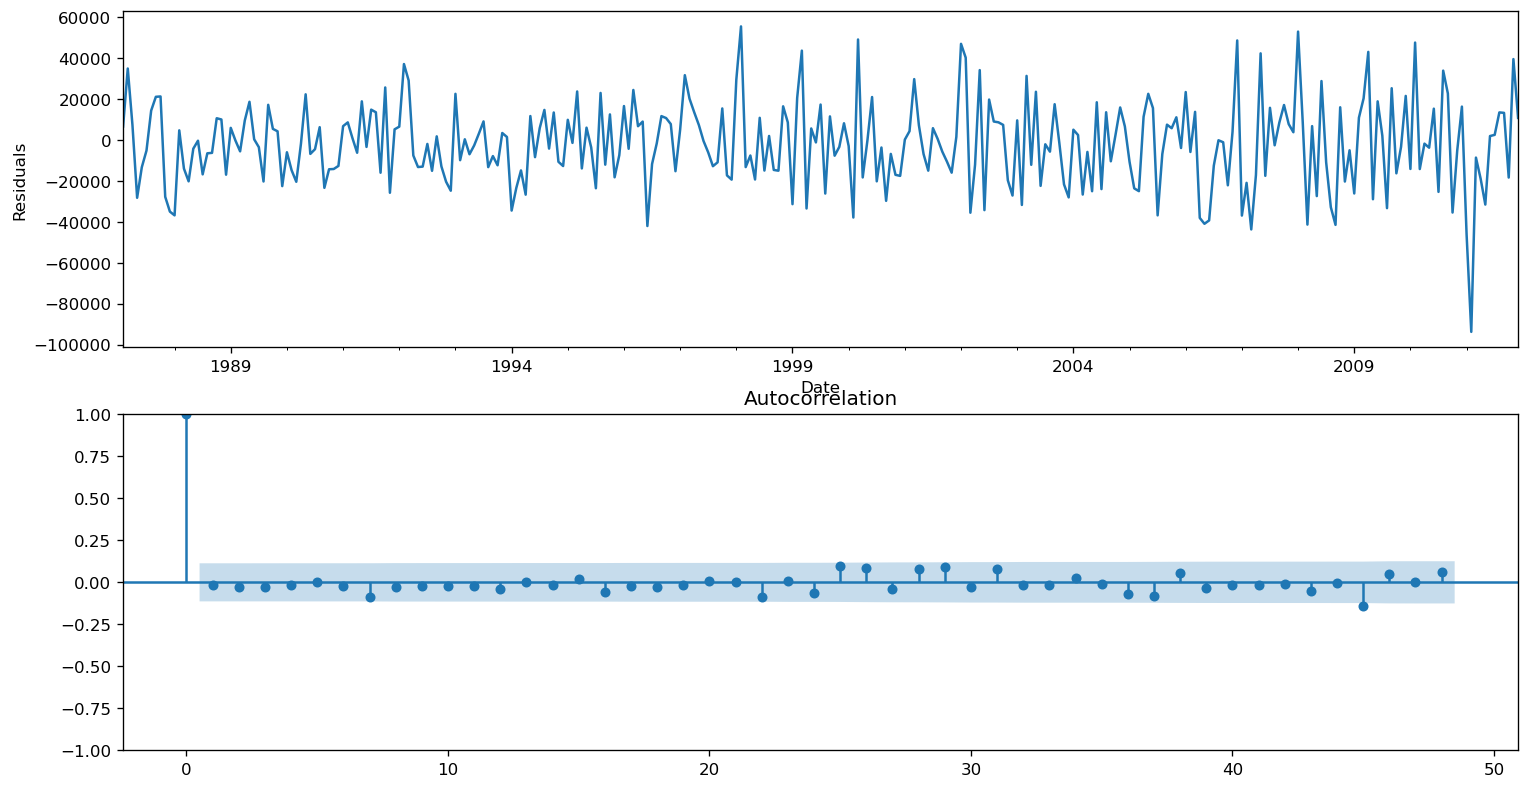

In [25]:
plt.figure(figsize = (15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)


print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

In [28]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

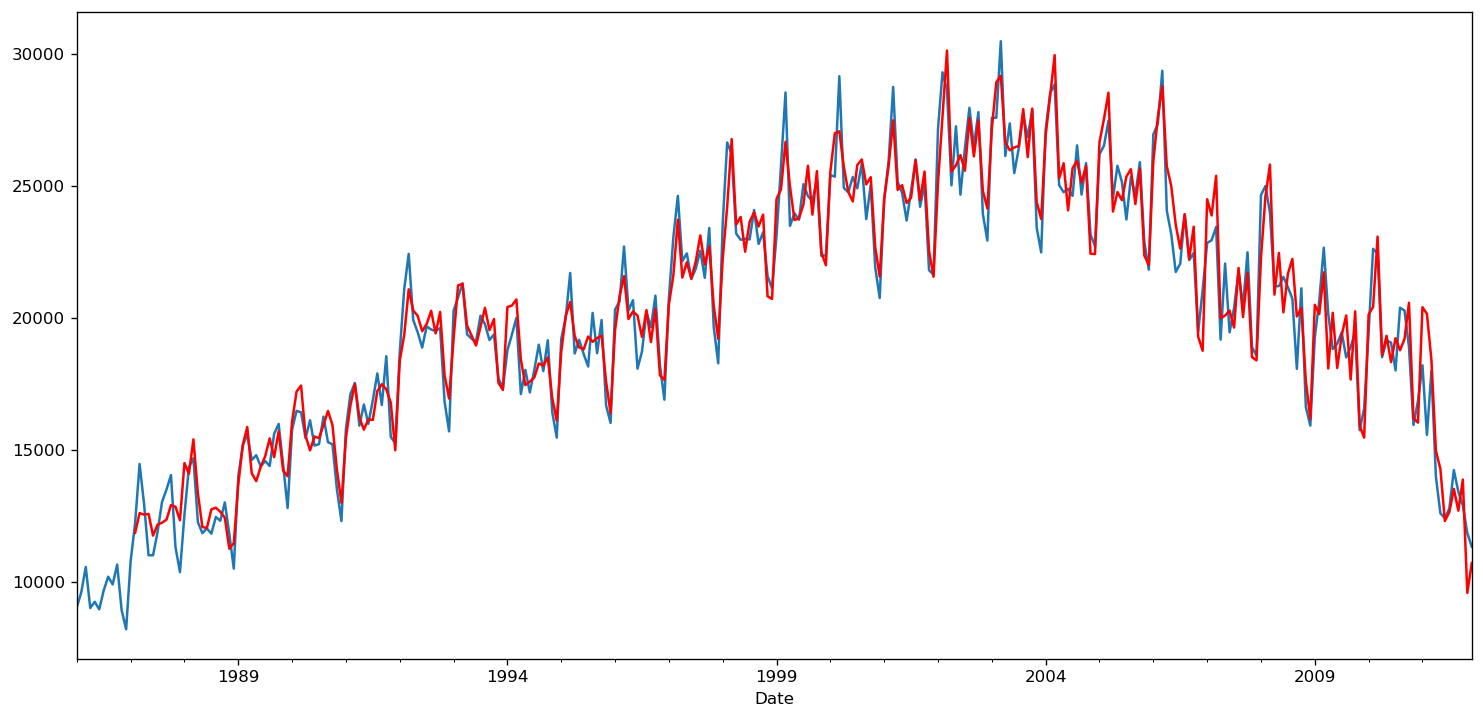

MAE = 768.5840364454453


In [29]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
df.Total.plot()
df.model[13:].plot(color='r')
plt.ylabel('')
plt.show()
print(f'MAE = {mean_absolute_error(df.Total[12:], df.model[12:])}')

Судя по графику, модель достаточно неплохо описывает данные, значение MAE в пределах нормы (вообще стоило бы считать значение MAE у каждой модели, параллельно AIC, но решили оставить так).
Таким образом, лучшая модель - SARIMA(2,1,12)x(0,1,12)

Прогноз:

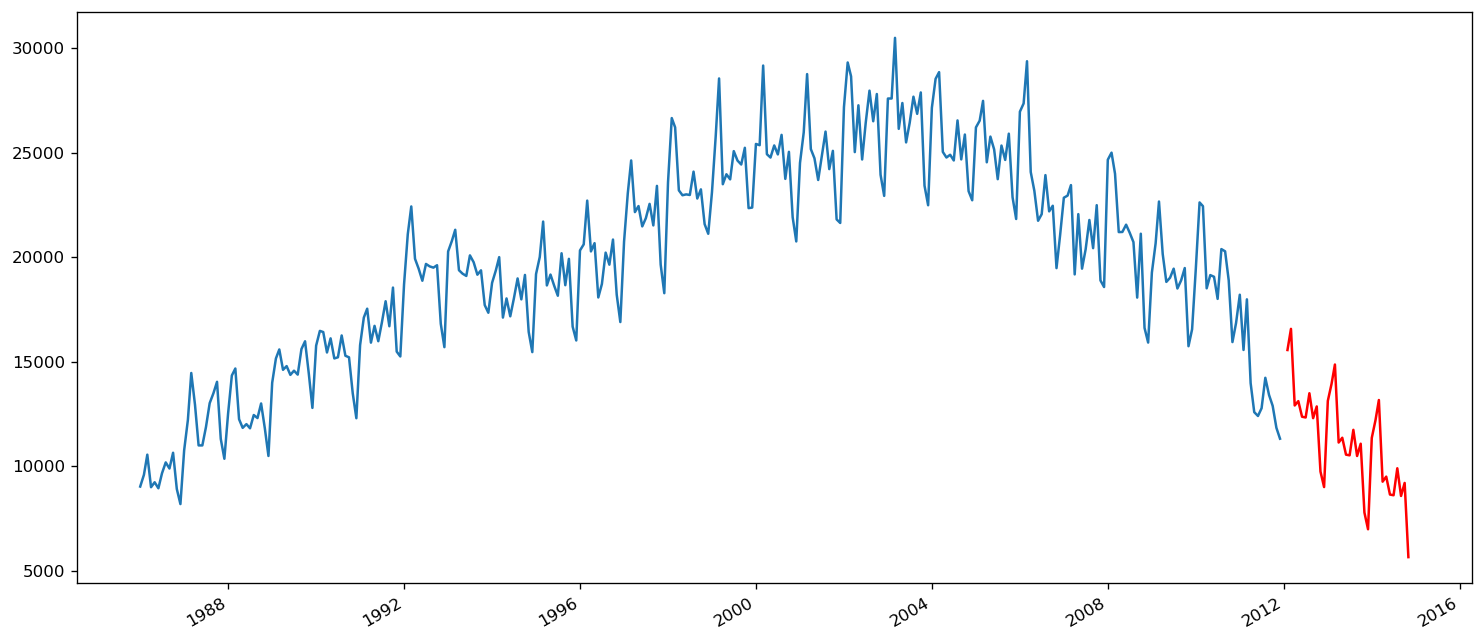

In [30]:
df2 = df[['Total']]
date_list = [datetime.strptime("2011-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=313, end=348), lmbda)

plt.figure(figsize=(15,7))
df2.Total.plot()
df2.forecast.plot(color='r')
plt.ylabel('')
plt.show()

# Выводы


Для того, чтобы сделать прогноз на 3 года, мы проанализировали наш временной ряд и сделали следующие действия:
- Посмотрели на график самого временного ряда, на график остатков, а также на график сезонности. В следствие чего нашли два тренда, сезонность, отсутсвие стационарности и увеличение разброса ошибок со временем.
- Проверили по критерию Дики-Фуллера стационарность ряда и выяснили, что ряд нестационарен.
- С помощью дифференцирования привели ряд к стационарному виду
- По графикам ACF и PACF определили параметры для модели SARIMA 
- Обучили модель и нашли лучшие параметры для SARIMA
- Сделали прогноз до 2015 года.

В итоге, наша лучшая модель оказалась SARIMA(2,1,12)x(0,1,12)